# Load Libraries

In [1]:
library(tidyverse)
library(data.table)

── Attaching packages ────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




# Load Data

In [2]:
load('../../3_1_2_processed_data/VIB_measure_cleaned_data2022-05-19.RData')

This loads:

- `q_df` | the full Qualtrics dataframe with text responses
- `qn_df` | full Qualtrics dataframe with numeric responses
- `ib_measures_df` | Intention behavior gap measures
- `validation_measures` | Individual difference questionnaires
- `demographics` | Basic demographics
- `ib_gap_domains` | Individual domain gaps

# Analysis

## Match Test/Retest Subjects

In [14]:
unique(qn_df$version)

[1] "vib"       "ib"        "ib_retest"

In [72]:
test = qn_df[qn_df$version!='ib_retest']$id
retest = qn_df[qn_df$version=='ib_retest']$id

In [73]:
# in retest 24036 and 23374 had really short rts on many of the measures so we are removing them...
retest = retest[retest!=c('24036', '23374')]

Warning message in retest != c("24036", "23374"):
“longer object length is not a multiple of shorter object length”


In [74]:
# find the people that appear twice...
test_retest_ids = test[test %in% retest]

In [78]:
# get subject IDs of matched subjects
trt = qn_df[qn_df$id %in% test_retest_ids] %>%
    select(subjectID, id, version)

In [79]:
trt$test_retest = ''
trt[trt$version!='ib_retest']$test_retest = 'test'
trt[trt$version=='ib_retest']$test_retest = 'retest'

In [80]:
trt_ib_gap = merge(trt, ib_measures_df, by = 'subjectID')

In [81]:
trt_ib_gap %>% setorder(id)

## Test-Retest Correlations

### IB Gap

In [159]:
test = trt_ib_gap[trt_ib_gap$test_retest =='test']$domain_gap
retest = trt_ib_gap[trt_ib_gap$test_retest == 'retest']$domain_gap

cor.test(test, retest)


	Pearson's product-moment correlation

data:  test and retest
t = 4.3326, df = 30, p-value = 0.000152
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3466964 0.7967307
sample estimates:
      cor 
0.6203907 


#### Bootstrap

With replacement

#### Permutation Test

Without replacement

[1] 3e-04

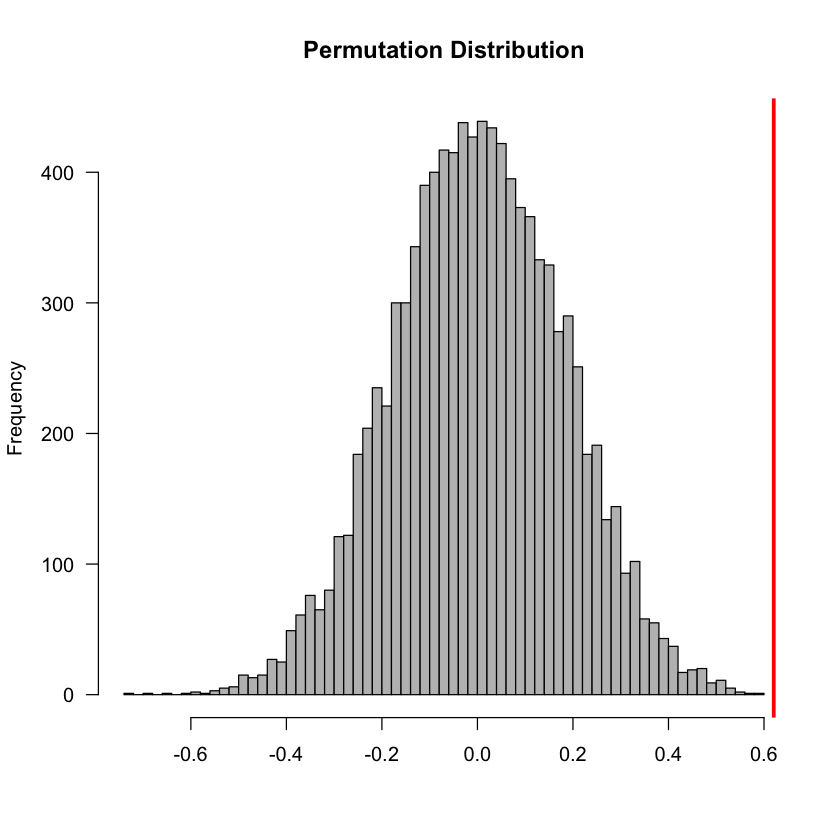

In [168]:
# Correlation
original <- cor.test(test, retest)$estimate[[1]]

#Permutation test
permutation.test <- function(test, retest, n){
  distribution=c()
  result=0
  for(i in 1:n){
    distribution[i]=cor.test(test, sample(retest, length(retest), FALSE))$estimate[[1]]
  }
  result=sum(abs(distribution) >= abs(original))/(n)
  return(list(result, distribution))
}

test1 <- permutation.test(test, retest, 10000)
hist(test1[[2]], breaks=50, col='grey', main="Permutation Distribution", las=1, xlab='')
abline(v=original, lwd=3, col="red")

test1[[1]]

#### Plot

`geom_smooth()` using formula 'y ~ x'



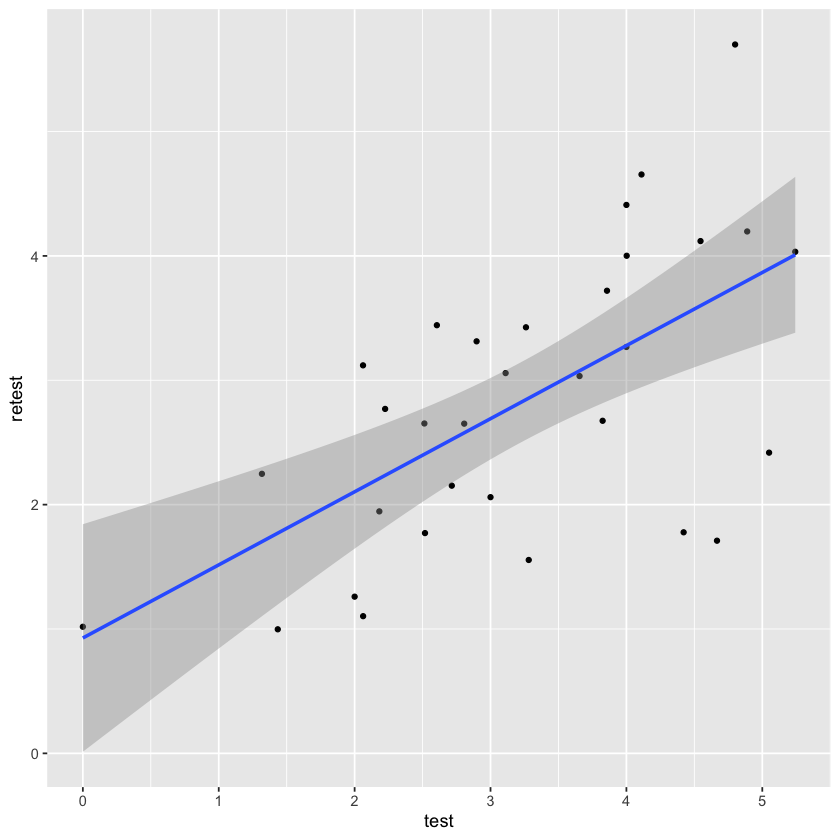

In [158]:
test <- trt_ib_gap %>%
    filter(test_retest == 'test') %>%
    pull(all_of(domain_gap))
retest <- trt_ib_gap %>%
    filter(test_retest == 'retest') %>%
    pull(all_of(domain_gap))

df <- data.frame(test, retest)

ggplot(df,aes(x=test,y=retest)) +
     geom_point(size=1.1)+
     geom_smooth(method = "glm", 
                 se = TRUE)  

<div class="alert alert-block alert-info">
    
<blockquote cite="http://www.worldwildlife.org/who/index.html">
the one-year test-retest stability of the Grit-S (r = .68) <br>
    compared favorably with Robins et al.’s (2001) <br>
    finding that NEO-FFI Conscientiousness scores <br>
    correlate across four years at r = .59
</blockquote>
    
<p>Duckworth, A. L., & Quinn, P. D. (2009). Development and validation of the Short Grit Scale (GRIT–S). Journal of personality assessment, 91(2), 166-174. </p>

</div>

### Validation Measures

In [93]:
trt_valid_gap = merge(trt, validation_measures, by = 'subjectID')

In [94]:
trt_valid_gap = trt_valid_gap[ , colSums(is.na(trt_valid_gap)) == 0, with = FALSE]
trt_valid_gap %>% setorder(id)
head(trt_valid_gap)

subjectID,id,version,test_retest,ambition_score,bscs_score,future_score,grit_score,swl_cantril_ladder,self_esteem_single_1
<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223,22641,ib,test,3.2,2.692308,4.3,2.125,3,2
319,22641,ib_retest,retest,4.2,2.846154,2.1,1.625,3,3
133,22670,vib,test,3.0,3.153846,1.4,2.750,2,4
292,22670,ib_retest,retest,4.6,3.230769,1.8,2.500,4,2
44,22708,vib,test,4.2,3.384615,4.1,3.750,5,3
322,22708,ib_retest,retest,3.8,3.153846,4.4,3.000,4,3


In [153]:
for (i in 5:ncol(trt_valid_gap)){
    print(names(trt_valid_gap)[i])
        
    test = trt_valid_gap %>%
    filter(test_retest == 'test') %>%
    pull(all_of(i))

    retest = trt_valid_gap %>%
    filter(test_retest == 'retest') %>%
    pull(all_of(i))
    x = cor.test(test, retest)
    print(x$estimate)
}

[1] "ambition_score"
      cor 
0.5462344 
[1] "bscs_score"
      cor 
0.8432658 
[1] "future_score"
      cor 
0.6658919 
[1] "grit_score"
      cor 
0.8052175 
[1] "swl_cantril_ladder"
     cor 
0.797721 
[1] "self_esteem_single_1"
    cor 
0.87989 


### Domain Specific Gaps

In [174]:
ib_gap_domains$subjectID = ib_gap_domains$ib_domain_gap_subjectID
trt_domain_gap = merge(trt, ib_gap_domains, by = 'subjectID')

In [197]:
n = dim(trt_domain_gap[trt_domain_gap$test_retest == 'test'])[1]

In [201]:
trt_domain_gap %>% setorder(id)

In [206]:
for (i in 5:ncol(trt_domain_gap)){
    print(names(trt_domain_gap)[i])
        
    test = trt_domain_gap %>%
    filter(test_retest == 'test') %>%
    pull(all_of(i))

    retest = trt_domain_gap %>%
    filter(test_retest == 'retest') %>%
    pull(all_of(i))
    x = cor.test(test, retest)
    print(x$estimate)
}

[1] "ib_domain_gap_Diet"
      cor 
0.7094545 
[1] "ib_domain_gap_Exercise"
      cor 
0.2973258 
[1] "ib_domain_gap_MentalPersonal_Health"
      cor 
0.4072628 
[1] "ib_domain_gap_Medical_Health"
      cor 
0.7530849 
[1] "ib_domain_gap_Sleep"
      cor 
0.2574227 
[1] "ib_domain_gap_Alcohol_drug"
      cor 
0.7194368 
[1] "ib_domain_gap_Online"
      cor 
0.3292116 
[1] "ib_domain_gap_Phone"
      cor 
0.2177083 
[1] "ib_domain_gap_Video games"
      cor 
0.8183805 
[1] "ib_domain_gap_Reading"
     cor 
0.749706 
[1] "ib_domain_gap_SocialMedia"
     cor 
0.333141 
[1] "ib_domain_gap_Sports"
      cor 
0.7679954 
[1] "ib_domain_gap_TV_Streaming"
      cor 
0.6604775 
[1] "ib_domain_gap_Family"
      cor 
0.4735411 
[1] "ib_domain_gap_Friends"
      cor 
0.3146989 
[1] "ib_domain_gap_Partner"
     cor 
0.512666 
[1] "ib_domain_gap_Social_life"
      cor 
0.3574153 
[1] "ib_domain_gap_Cleaning"
      cor 
0.4535543 
[1] "ib_domain_gap_Housework"
      cor 
0.9031103 
[1] "ib_domain_gap_

In [200]:
for (i in 1:n){
    
}

In [186]:
which(!is.na(trt_domain_gap[1,]))

[1]  1  2  3  4  6  7 12 13 14 18 19 20 21 25 36 37

In [184]:
trt_domain_gap[1, c(1,2,3)]

subjectID,id,version
<int>,<chr>,<chr>
13,23479,vib


In [193]:
which(!is.na(trt_domain_gap[39,]))

[1]  1  2  3  4  7  9 10 14 21 25 27 28 29 33 35 36 37

In [202]:
trt_domain_gap

subjectID,id,version,test_retest,ib_domain_gap_Diet,ib_domain_gap_Exercise,ib_domain_gap_MentalPersonal_Health,ib_domain_gap_Medical_Health,ib_domain_gap_Sleep,ib_domain_gap_Alcohol_drug,⋯,ib_domain_gap_Learning,ib_domain_gap_Self-Improvement,ib_domain_gap_Volunteering,ib_domain_gap_Community involvement,ib_domain_gap_Admin,ib_domain_gap_Future_Planning,ib_domain_gap_Finances,ib_domain_gap_Time_Management,ib_domain_gap_Punctuality,ib_domain_gap_subjectID
<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
223,22641,ib,test,5.28,4.08,4.86,6.06,3.96,NA,⋯,6.00,6.06,NA,NA,6.06,6.06,6.06,5.16,5.46,223
319,22641,ib_retest,retest,1.98,2.64,4.26,5.76,6.06,NA,⋯,5.28,6.06,6.06,NA,6.06,6.06,6.06,5.88,0.96,319
133,22670,vib,test,6.00,6.00,NA,NA,6.00,NA,⋯,NA,4.00,6.00,3.00,NA,5.00,6.00,2.00,1.00,133
292,22670,ib_retest,retest,5.82,4.74,6.06,NA,0.84,NA,⋯,NA,NA,4.20,4.26,NA,NA,NA,0.06,0.06,292
44,22708,vib,test,1.50,1.50,1.50,4.50,4.50,1.50,⋯,4.50,1.50,6.00,6.00,NA,NA,3.00,1.50,0.00,44
322,22708,ib_retest,retest,0.60,1.56,1.44,1.38,1.32,0.66,⋯,NA,0.36,5.28,5.22,NA,5.28,2.22,1.62,0.24,322
92,22921,vib,test,5.00,6.00,5.00,NA,5.00,2.00,⋯,5.00,NA,6.00,NA,NA,5.00,5.00,4.00,4.00,92
310,22921,ib_retest,retest,4.68,3.96,4.98,NA,4.98,0.06,⋯,3.96,4.14,5.88,NA,5.64,4.92,5.64,4.14,3.06,310
176,22963,ib,test,0.36,0.36,1.98,2.52,0.48,0.06,⋯,2.82,1.50,1.62,1.74,2.64,2.52,2.58,2.34,1.56,176
